
# TABNET


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Modelos clásicos
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, mean_absolute_error, r2_score
)

# TabNet
!pip install pytorch-tabnet > /dev/null
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

# Utilidades
import warnings
warnings.filterwarnings("ignore")


Instalamos la libreria para usar tabent

In [ ]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.8 MB/s eta 0:00:00


## Cargamos nuestros datos

In [ ]:
final_dataset_path = '/content/drive/MyDrive/ConcentracionIA_bloque2/VSS/final_dataset.csv'

df = pd.read_csv(final_dataset_path)
df.head()

,Fecha,Número del animal,Nº Lactación,Estado de la reproducción,Días en ordeño,Número de inseminaciones,Días preñada,Días para el parto,Producción de leche ayer,Producción media diaria últimos 7 días,Producción TOTAL en lactación,Estado de Producción,Estado de Producción Codificado
0,2024-11-21,1203,1,Inseminada,0,0,0,0,0.00,2.280000,2.28,En Producción,1
1,2024-11-21,1203,1,Fresca,0,0,0,0,2.28,2.280000,2.28,En Producción,1
2,2024-11-22,1203,1,Fresca,1,0,0,0,2.28,5.200000,10.40,En Producción,1
3,2024-11-23,1203,1,Fresca,2,0,0,0,8.12,7.053333,21.16,En Producción,1
4,2024-11-24,1203,1,Fresca,3,0,0,0,10.76,10.165000,40.66,En Producción,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71356 entries, 0 to 71355
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Fecha                                   71356 non-null  object 
 1   Número del animal                       71356 non-null  int64  
 2   Nº Lactación                            71356 non-null  int64  
 3   Estado de la reproducción               71356 non-null  object 
 4   Días en ordeño                          71356 non-null  int64  
 5   Número de inseminaciones                71356 non-null  int64  
 6   Días preñada                            71356 non-null  int64  
 7   Días para el parto                      71356 non-null  int64  
 8   Producción de leche ayer                71356 non-null  float64
 9   Producción media diaria últimos 7 días  71356 non-null  float64
 10  Producción TOTAL en lactación           71356 non-null  fl

In [ ]:
print("Conteo de datos por cada clase en 'Estado de Producción':")
print(df['Estado de Producción'].value_counts())

Conteo de datos por cada clase en 'Estado de Producción':
Estado de Producción
En Producción      67717
En Monitoreo        2452
Previo a Secado     1187
Name: count, dtype: int64


# DATA AUGMENTATION

In [ ]:
def augment_animal_sequence(df_animal, n_augmentations=5):
    """
    Augmenta datos de un animal específico con reglas realistas por estado
    """
    augmented_data = []
    estado = df_animal['Estado de Producción'].iloc[0]

    for _ in range(n_augmentations):
        df_aug = df_animal.copy()

        if estado == 'En Monitoreo':
            noise_factor = 0.03
            df_aug['Producción de leche ayer'] *= (1 + np.random.normal(0, noise_factor, len(df_aug)))
            df_aug['Producción de leche ayer'] = df_aug['Producción de leche ayer'].clip(upper=25.0)
            df_aug['Producción media diaria últimos 7 días'] *= (1 + np.random.normal(0, noise_factor, len(df_aug)))
            df_aug['Producción media diaria últimos 7 días'] = df_aug['Producción media diaria últimos 7 días'].clip(upper=25.0)

        elif estado == 'Preñada':
            noise_factor = 0.05
            df_aug['Producción de leche ayer'] *= (1 + np.random.normal(0, noise_factor, len(df_aug)))
            df_aug['Producción de leche ayer'] = df_aug['Producción de leche ayer'].clip(lower=20.0, upper=50.0)
            df_aug['Producción media diaria últimos 7 días'] *= (1 + np.random.normal(0, noise_factor, len(df_aug)))
            df_aug['Producción media diaria últimos 7 días'] = df_aug['Producción media diaria últimos 7 días'].clip(lower=20.0, upper=50.0)

        elif estado == 'Seca':
            df_aug['Producción de leche ayer'] = 0.0
            df_aug['Producción media diaria últimos 7 días'] = 0.0

        else:
            noise_factor = 0.05
            df_aug['Producción de leche ayer'] *= (1 + np.random.normal(0, noise_factor, len(df_aug)))
            df_aug['Producción media diaria últimos 7 días'] *= (1 + np.random.normal(0, noise_factor, len(df_aug)))

        shift_days = np.random.randint(-3, 4)
        df_aug['Días en ordeño'] = (df_aug['Días en ordeño'] + shift_days).clip(lower=0)

        if len(df_aug) > 3:
            mask = np.random.choice([True, False], size=len(df_aug), p=[0.2, 0.8])
            for col in ['Producción de leche ayer', 'Producción media diaria últimos 7 días']:
                if df_aug[col].sum() > 0:
                    df_aug.loc[mask, col] = df_aug[col].interpolate(method='linear')

        augmented_data.append(df_aug)

    return pd.concat(augmented_data, ignore_index=True)

def balance_dataset(df, target_col='Estado de Producción', min_samples=10000):
    """
    Balancea el dataset con augmentación realista
    """
    class_counts = df[target_col].value_counts()
    balanced_dfs = []

    print("=" * 80)
    print("BALANCEO DE DATASET CON REGLAS REALISTAS")
    print("=" * 80)
    print(f"\nDistribución ORIGINAL:")
    for estado, count in class_counts.items():
        print(f"  {estado}: {count} registros")

    for estado in df[target_col].unique():
        df_estado = df[df[target_col] == estado]
        current_count = len(df_estado)

        if current_count < min_samples:
            n_augmentations = (min_samples // current_count) + 1
            print(f"\nProcesando '{estado}': {current_count} → {current_count * n_augmentations} registros")

            animals = df_estado['Número del animal'].unique()
            for animal in animals:
                df_animal = df_estado[df_estado['Número del animal'] == animal]
                augmented = augment_animal_sequence(df_animal, n_augmentations)
                balanced_dfs.append(augmented)
        else:
            print(f"\n✓ '{estado}' ya tiene suficientes muestras: {current_count}")
            balanced_dfs.append(df_estado)

    result_df = pd.concat(balanced_dfs, ignore_index=True)

    print("\n" + "=" * 80)
    print("DISTRIBUCIÓN FINAL:")
    print("=" * 80)
    final_counts = result_df[target_col].value_counts()
    for estado, count in final_counts.items():
        print(f"  {estado}: {count} registros")

    return result_df

df_balanced = balance_dataset(df)

print("\n" + "=" * 80)
print("VALIDACIÓN DE RANGOS DE PRODUCCIÓN POR ESTADO")
print("=" * 80)

for estado in df_balanced['Estado de Producción'].unique():
    df_estado = df_balanced[df_balanced['Estado de Producción'] == estado]
    prod_ayer = df_estado['Producción de leche ayer']
    prod_media = df_estado['Producción media diaria últimos 7 días']

    print(f"\n{estado}:")
    print(f"  Producción ayer - Min: {prod_ayer.min():.2f}, Max: {prod_ayer.max():.2f}, Media: {prod_ayer.mean():.2f}")
    print(f"  Producción media 7d - Min: {prod_media.min():.2f}, Max: {prod_media.max():.2f}, Media: {prod_media.mean():.2f}")

print("\n" + "=" * 80)
print("VERIFICACIÓN DE CASOS PROBLEMÁTICOS")
print("=" * 80)

en_monitoreo_alta = df_balanced[
    (df_balanced['Estado de Producción'] == 'En Monitoreo') &
    (df_balanced['Producción de leche ayer'] > 25)
]
print(f"\nRegistros 'En Monitoreo' con producción > 25 litros: {len(en_monitoreo_alta)}")
if len(en_monitoreo_alta) > 0:
    print("   (Esto NO debería ocurrir con las nuevas reglas)")

prenada_muy_baja = df_balanced[
    (df_balanced['Estado de Producción'] == 'Preñada') &
    (df_balanced['Producción de leche ayer'] < 15)
]
print(f"\nRegistros 'Preñada' con producción < 15 litros: {len(prenada_muy_baja)}")

print("\nDataset balanceado con reglas realistas completado")
print(f"Total de registros: {len(df_balanced)}")
print(f"Forma del DataFrame: {df_balanced.shape}")

BALANCEO DE DATASET CON REGLAS REALISTAS

Distribución ORIGINAL:
  En Producción: 67717 registros
  En Monitoreo: 2452 registros
  Previo a Secado: 1187 registros

✓ 'En Producción' ya tiene suficientes muestras: 67717

Procesando 'En Monitoreo': 2452 → 12260 registros

Procesando 'Previo a Secado': 1187 → 10683 registros

DISTRIBUCIÓN FINAL:
  En Producción: 67717 registros
  En Monitoreo: 12260 registros
  Previo a Secado: 10683 registros

VALIDACIÓN DE RANGOS DE PRODUCCIÓN POR ESTADO

En Producción:
  Producción ayer - Min: 0.00, Max: 110.99, Media: 37.39
  Producción media 7d - Min: 0.60, Max: 80.07, Media: 37.36

En Monitoreo:
  Producción ayer - Min: 0.00, Max: 25.00, Media: 22.27
  Producción media 7d - Min: 7.86, Max: 25.00, Media: 23.40

Previo a Secado:
  Producción ayer - Min: 0.00, Max: 58.76, Media: 20.65
  Producción media 7d - Min: 5.27, Max: 39.80, Media: 23.59

VERIFICACIÓN DE CASOS PROBLEMÁTICOS

Registros 'En Monitoreo' con producción > 25 litros: 0

Registros 'Preña

In [ ]:
df_balanced['Estado de Producción'].value_counts()

,count
Estado de Producción,
En Producción,67717
En Monitoreo,12260
Previo a Secado,10683


In [ ]:
df_balanced.head()

,Fecha,Número del animal,Nº Lactación,Estado de la reproducción,Días en ordeño,Número de inseminaciones,Días preñada,Días para el parto,Producción de leche ayer,Producción media diaria últimos 7 días,Producción TOTAL en lactación,Estado de Producción,Estado de Producción Codificado
0,2024-11-21,1203,1,Inseminada,0,0,0,0,0.00,2.280000,2.28,En Producción,1
1,2024-11-21,1203,1,Fresca,0,0,0,0,2.28,2.280000,2.28,En Producción,1
2,2024-11-22,1203,1,Fresca,1,0,0,0,2.28,5.200000,10.40,En Producción,1
3,2024-11-23,1203,1,Fresca,2,0,0,0,8.12,7.053333,21.16,En Producción,1
4,2024-11-24,1203,1,Fresca,3,0,0,0,10.76,10.165000,40.66,En Producción,1


In [ ]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90660 entries, 0 to 90659
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Fecha                                   90660 non-null  object 
 1   Número del animal                       90660 non-null  int64  
 2   Nº Lactación                            90660 non-null  int64  
 3   Estado de la reproducción               90660 non-null  object 
 4   Días en ordeño                          90660 non-null  int64  
 5   Número de inseminaciones                90660 non-null  int64  
 6   Días preñada                            90660 non-null  int64  
 7   Días para el parto                      90660 non-null  int64  
 8   Producción de leche ayer                90660 non-null  float64
 9   Producción media diaria últimos 7 días  90660 non-null  float64
 10  Producción TOTAL en lactación           90660 non-null  fl

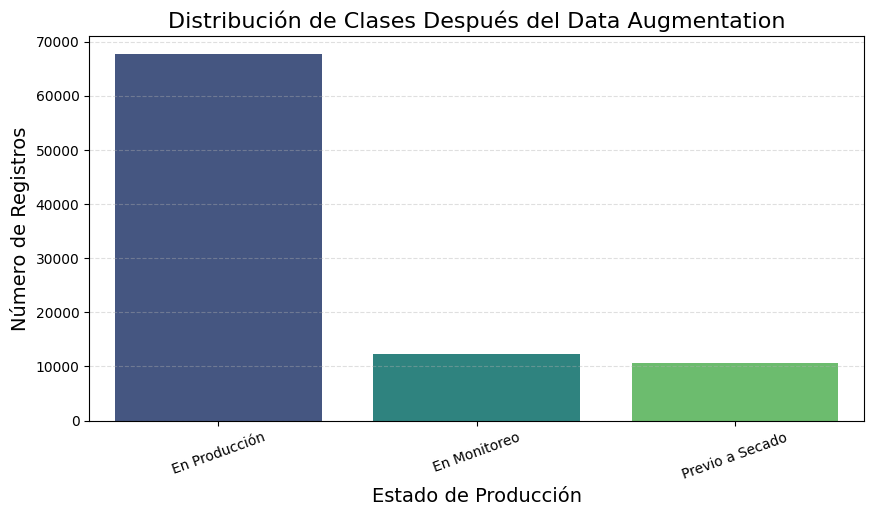

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_balanced, x='Estado de Producción', palette='viridis')

plt.title("Distribución de Clases Después del Data Augmentation", fontsize=16)
plt.xlabel("Estado de Producción", fontsize=14)
plt.ylabel("Número de Registros", fontsize=14)
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()

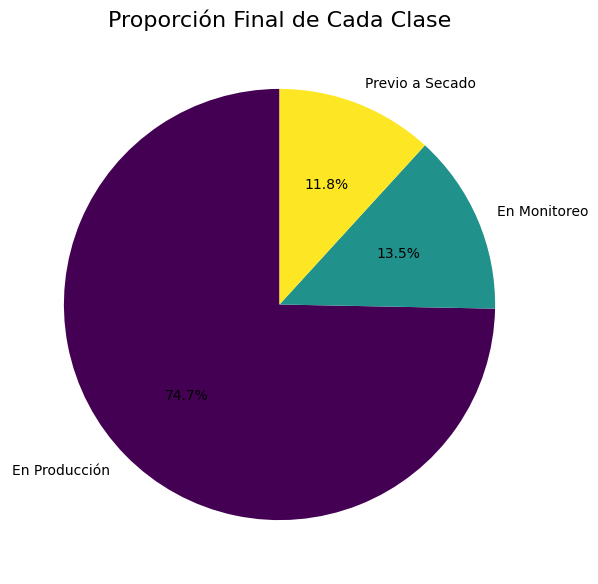

In [ ]:
plt.figure(figsize=(7,7))

df_balanced['Estado de Producción'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', startangle=90, cmap='viridis'
)

plt.title("Proporción Final de Cada Clase", fontsize=16)
plt.ylabel("")  # quitar etiqueta
plt.show()

# MODELO

In [ ]:
# ============================
# CONFIGURACIÓN BASE
# ============================

TARGET = "Estado de Producción Codificado"

X = df_balanced.drop(['Fecha',
                      'Número del animal',
                      'Estado de la reproducción',
                      'Estado de Producción',
                      'Estado de Producción Codificado',
                      'Estado de Producción Codificado'], axis=1).copy()

y = df_balanced[TARGET]

# LabelEncoder para el target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# LabelEncoder para features categóricas
categorical_cols = X.select_dtypes(include=['object']).columns
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

print("Features y target preparados")


Features y target preparados


In [ ]:
# Train / temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.40, random_state=42, stratify=y_encoded
)

# Validation / test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("División completada:")
print("Train:", len(X_train))
print("Val:", len(X_val))
print("Test:", len(X_test))


División completada:
Train: 54396
Val: 18132
Test: 18132


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import torch

# Pesos inversamente proporcionales a la frecuencia
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

print("Pesos por clase:", class_weights)

# Convertimos a tensor para usar en loss_fn
weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights_tensor)


# ======================================
# 2. Modelo TabNet (configuración estable)
# ======================================
tabnet = TabNetClassifier(
    n_d=32,                   # capacidad estable
    n_a=32,
    n_steps=5,
    gamma=1.5,                # este valor te dio excelente rendimiento
    lambda_sparse=1e-4,       # suave, evita ignorar features
    optimizer_params=dict(lr=2e-3),  # aprendizaje óptimo
    seed=42,
    verbose=1
)


# ======================================
# 3. Entrenamiento con early stopping
# ======================================
tabnet.fit(
    X_train.values, y_train,
    eval_set=[(X_val.values, y_val)],
    eval_name=["val"],
    eval_metric=["accuracy"],
    loss_fn=loss_fn,               # <-- AQUÍ APLICAMOS LOS PESOS
    max_epochs=80,
    patience=10,
    batch_size=2048,
    virtual_batch_size=256
)

Pesos por clase: [2.46492659 0.44627123 2.82870515]
epoch 0  | loss: 1.13115 | val_accuracy: 0.77327 |  0:00:09s
epoch 1  | loss: 0.62624 | val_accuracy: 0.77107 |  0:00:14s
epoch 2  | loss: 0.53458 | val_accuracy: 0.7762  |  0:00:21s
epoch 3  | loss: 0.48767 | val_accuracy: 0.78088 |  0:00:27s
epoch 4  | loss: 0.45075 | val_accuracy: 0.7885  |  0:00:32s
epoch 5  | loss: 0.42625 | val_accuracy: 0.79362 |  0:00:39s
epoch 6  | loss: 0.40891 | val_accuracy: 0.79544 |  0:00:44s
epoch 7  | loss: 0.41409 | val_accuracy: 0.80074 |  0:00:51s
epoch 8  | loss: 0.39532 | val_accuracy: 0.80135 |  0:00:56s
epoch 9  | loss: 0.40902 | val_accuracy: 0.80863 |  0:01:02s
epoch 10 | loss: 0.40348 | val_accuracy: 0.81508 |  0:01:09s
epoch 11 | loss: 0.4232  | val_accuracy: 0.85732 |  0:01:14s
epoch 12 | loss: 0.38576 | val_accuracy: 0.8539  |  0:01:21s
epoch 13 | loss: 0.37316 | val_accuracy: 0.87613 |  0:01:26s
epoch 14 | loss: 0.36147 | val_accuracy: 0.87773 |  0:01:33s
epoch 15 | loss: 0.3913  | val_ac

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Predicción
y_pred = tabnet.predict(X_test.values)

# Métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n============================")
print(" RESULTADOS TABNET")
print("============================")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

print("\nReporte completo:")

# --- FIX START ---
# The error occurs because le_target.classes_ contains integers, but classification_report expects string names.
# We need to get the original string names from the 'Estado de Producción' column
# and map them to the encoded numerical labels (0, 1, 2...) in the correct order.

# Create a mapping from the numerical 'Estado de Producción Codificado' to the string 'Estado de Producción'
class_mapping = df_balanced[['Estado de Producción Codificado', 'Estado de Producción']].drop_duplicates()
# Sort by the codified value to ensure the target_names are in the correct order (0, 1, 2...)
class_mapping = class_mapping.sort_values('Estado de Producción Codificado')
# Extract the string labels in the correct order
correct_target_names = class_mapping['Estado de Producción'].tolist()

print(classification_report(y_test, y_pred, target_names=correct_target_names))
# --- FIX END ---


 RESULTADOS TABNET
Accuracy:  0.8893
Precision: 0.7781
Recall:    0.8709
F1 Score:  0.8161

Reporte completo:
                 precision    recall  f1-score   support

   En Monitoreo       0.74      0.92      0.82      2452
  En Producción       0.99      0.90      0.94     13544
Previo a Secado       0.60      0.80      0.69      2136

       accuracy                           0.89     18132
      macro avg       0.78      0.87      0.82     18132
   weighted avg       0.91      0.89      0.90     18132



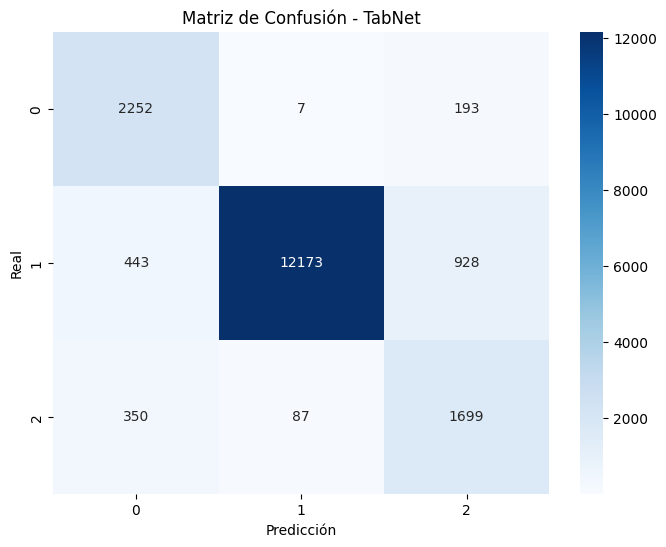

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.title("Matriz de Confusión - TabNet")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()